In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [174]:
df=pd.read_csv('ford.csv')

In [175]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6
17964,KA,2018,8299,Manual,5007,Petrol,145,57.7,1.2


In [176]:
# Выбор фичей
feature = df.drop('price', axis=1)

In [177]:
# Выбор целей
target = df['price']

## В качестве базовой модели регрессии я выбрал h2o 

In [178]:
import h2o
from h2o.automl import H2OAutoML

In [179]:
df=df.drop(columns='model')
df=df.drop(columns='transmission')
df=df.drop(columns='fuelType')

In [180]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 9 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Кирилл_kaiyhe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.409 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [181]:
X_train, X_val, y_train, y_val = train_test_split(feature,
                                                  target,
                                                  test_size=0.2, 
                                                  random_state=123)

In [182]:
# Prepare the data
Xy_train = X_train.reset_index(drop=True)
Xy_train['SalePrice'] = y_train.reset_index(drop=True)

Xy_val = X_val.reset_index(drop=True)
Xy_val['SalePrice'] = y_val.reset_index(drop=True)
Xy_train_h2o = h2o.H2OFrame(Xy_train)
X_val_h2o = h2o.H2OFrame(X_val)
# Create the model
h2o_model = H2OAutoML(max_runtime_secs=120, seed=123)

# Fit the model
h2o_model.train(x=Xy_train_h2o.columns, y='SalePrice', training_frame=Xy_train_h2o)

# Predict the training data
h2o_pred = h2o_model.predict(X_val_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
20:27:13.154: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


C:\Users\grias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'fuelType' has levels not trained on: ["Other"]
  warnings.warn(w)


In [183]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE

# Convert back H2ODataFrame to Pandas DataFrame
h2o_pred_ = h2o.as_list(h2o_pred['predict'])
h2o_pred_ = h2o_pred_['predict']

## График реальных и предсказанных значений

RMSE: 1202.204
MAE: 788.197
R: 0.97


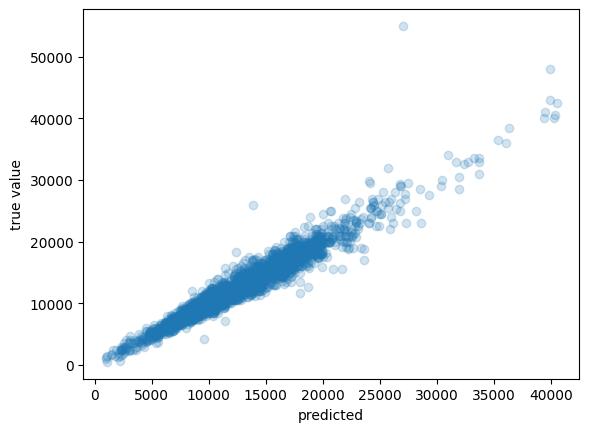

In [184]:
# Scatter plot true and predicted values
plt.scatter(h2o_pred_, y_val, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
# plt.text(100000, 400000, 'RMSE: ' + str(round(MSE(y_val, h2o_pred_)**0.5,3)))
# plt.text(100000, 350000, 'MAE: ' + str(round(mean_absolute_error(y_val, h2o_pred_),3)))
# plt.text(100000, 300000, 'R: ' + str(round(np.corrcoef(y_val, h2o_pred_)[0,1],3)))
print('RMSE: ' + str(round(MSE(y_val, h2o_pred_)**0.5,3)))
print('MAE: ' + str(round(mean_absolute_error(y_val, h2o_pred_),3)))
print('R: ' + str(round(np.corrcoef(y_val, h2o_pred_)[0,1],3)))
plt.show()

In [185]:
df=df.drop_duplicates()

# df['model'] = df['model'].str.lower()
# df['model'].value_counts(dropna=False)

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

df_numeric=df.select_dtypes(include=[np.number])
numeric_cols=df_numeric.columns.values

for i in non_numeric_cols:
  df[f'{i}']=df[i].str.strip('123.!? \n\t')
  df[f'{i}'] = df[f'{i}'].str.lower()
  df[f'{i}'].value_counts(dropna=False)
  df[i]=df[f'{i}']

df.columns=df.columns.str.lower()


## Удаление аномалий с помощью межквартильного диапозона

In [199]:
for x in ['price']:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
df

,year,price,mileage,tax,mpg,enginesize
0,2017,12000.0,15944,150,57.7,1.0
1,2018,14000.0,9083,150,57.7,1.0
2,2017,13000.0,12456,150,57.7,1.0
3,2019,17500.0,10460,145,40.3,1.5
4,2019,16500.0,1482,145,48.7,1.0
...,...,...,...,...,...,...
17961,2017,8999.0,16700,150,47.1,1.4
17962,2014,7499.0,40700,30,57.7,1.0
17963,2015,9999.0,7010,20,67.3,1.6
17964,2018,8299.0,5007,145,57.7,1.2


In [200]:
df = df.dropna(axis = 0)

## Подготовка к обучению модели

In [201]:
# Выбор фичей
feature = df.drop('price', axis=1)

In [202]:
# Выбор целей
target = df['price']

In [203]:
# Разделение на тестовую и обучающую выборки

X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

Как RMSE, так и R-квадрат количественно определяют, насколько хорошо модель линейной регрессии соответствует набору данных. RMSE показывает, насколько хорошо регрессионная модель может предсказать значение переменной отклика в абсолютном выражении, в то время как R-квадрат показывает, насколько хорошо переменные-предсказатели могут объяснить изменение переменной отклика.


In [204]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [205]:
X = df.drop('price', axis=1)
y = df['price']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [207]:
from sklearn import tree

## Я выбрал модель дерева решений

In [208]:
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

In [209]:
y_pred_2=clf.predict(X_test)

### Простое сравнение реальных значений от предсказанных моделью

In [210]:
df_1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2}) 
df_1


,Actual,Predicted
15697,6495.0,5899.0
15236,10999.0,10731.0
5793,10491.0,11990.0
2329,9995.0,11495.0
7502,9598.0,9495.0
...,...,...
12153,14770.0,17000.0
15332,14800.0,13699.0
8683,12990.0,11000.0
1271,10998.0,10600.0


## График реальных и предсказанных значений

RMSE: 1650.65
MAE: 1160.766
R: 0.92


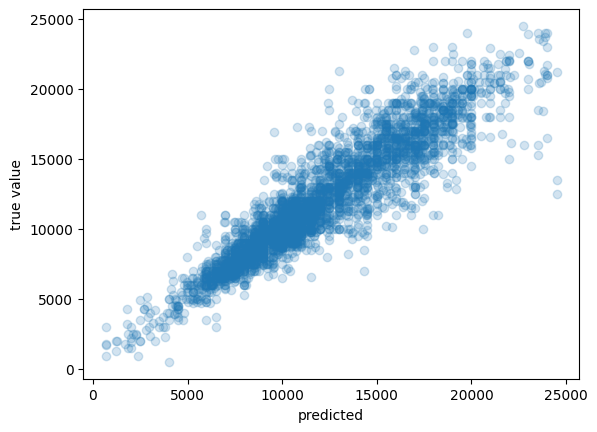

In [211]:
plt.scatter(y_pred_2, y_test, alpha=0.2)
plt.xlabel('predicted')
plt.ylabel('true value')
print('RMSE: ' + str(round(MSE(y_test, y_pred_2)**0.5,3)))
print('MAE: ' + str(round(mean_absolute_error(y_test, y_pred_2),3)))
print('R: ' + str(round(np.corrcoef(y_test, y_pred_2)[0,1],3)))

# У меня не получается сделать модель лучше, чем h2o. Я честно пытался 3 дня, но это лучший результат по RMSE, MAE и R, который я смог получить.